## EE 443 Final Project: Data Preparation Documentation 
#### Name: Jonathan Wong


### ---- Download Data ----
First, download the training data onto the local colab machine.

Then, restart runtime before continuing.

In [2]:
%tensorflow_version 1.x
import tensorflow as tf
import cv2, os, json
import argparse 
import shlex

def parse_args(input):
    parser = argparse.ArgumentParser(description="Train FGVC Network")

    parser.add_argument(
        "--input_path",
        help="input train/test splitting files",
        required=True,
        type=str,
    )
    parser.add_argument(
        "--cls_names_path",
        help="path for class name file",
        type=str,
        required=True
    )
    parser.add_argument(
        "--output_path",
        help="save path for converted file",
        type=str,
        required=False,
        default="."
    )

    # Input stuff
    input_list = shlex.split(input) 
    args = parser.parse_args(input_list)

    return args

def read_and_decode(filename_queue):
    """Parses a single tf.Example into image and label tensors."""
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        features={
            "image": tf.FixedLenFeature([], tf.string),
            "label": tf.FixedLenFeature([], tf.int64),
        })
    image = tf.decode_raw(features["image"], tf.uint8)
    image.set_shape([3 * 32 * 32])
    label = tf.cast(features["label"], tf.int32)
    return image, label

def convert_from_tfrecords(data_root, dir_name, num_class, mode, output_path, json_file_prefix, cls_names):
    if mode == 'test':
        tfrecord_path = os.path.join(data_root, dir_name, 'eval.tfrecords')
    else:
        tfrecord_path = os.path.join(data_root, dir_name, 'train.tfrecords')
    filename_queue = tf.train.string_input_producer([tfrecord_path], shuffle=False, num_epochs=1)

    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)
    image, label = read_and_decode(filename_queue)

    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess = tf.Session()
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    annotations = []
    try:
        step = 0
        while not coord.should_stop():
            images, labels = sess.run([image, label])
            if int(labels) % 2 != 0:
                continue
            images = cv2.cvtColor(images.reshape(3, 32, 32).transpose(1, 2, 0), cv2.COLOR_RGB2BGR)
            im_path = os.path.join(output_path, json_file_prefix, 'images', cls_names[int(labels)])
            if not os.path.exists(im_path):
                os.makedirs(im_path)
            save_path = os.path.join(im_path, '{}_{}.jpg'.format(mode, step))
            cv2.imwrite(save_path, images)
            annotations.append(
                {'fpath': save_path, 'image_id': step, 'category_id': int(labels), 'category': cls_names[int(labels)]})
            step += 1
    except tf.errors.OutOfRangeError:
        print('done')
    finally:
        coord.request_stop()

    with open(os.path.join(output_path, json_file_prefix, json_file_prefix + '_{}.json'.format(mode)), 'w') as f:
        json.dump({'annotations': annotations, 'num_classes': num_class}, f)

    print('Json has been saved to',
          os.path.join(output_path, json_file_prefix, json_file_prefix + '_{}.json'.format(mode)))


TensorFlow 1.x selected.


In [3]:
modes = ['train', 'test']
input = "--input_path /content/drive/MyDrive/EE_443/Final_Project/cifar-100-data " + \
        "--cls_names_path /content/drive/MyDrive/EE_443/Final_Project/cifar100_clsname.json "

args = parse_args(input)
with open(args.cls_names_path) as f:
    cls_names = json.load(f)

# you can add other datasets as follows
cifar100_im_1 = {'dir': 'cifar-100-data', 'json': 'cifar50', 'class': 50}
cifar100_im_01 = {'dir': 'cifar-100-data-im-0.1', 'json': 'cifar50_imbalance_0.1', 'class': 50}
cifar100_im_002 = {'dir': 'cifar-100-data-im-0.02', 'json': 'cifar50_imbalance_0.02', 'class': 50}
cifar100_im_0005 = {'dir': 'cifar-100-data-im-0.005', 'json': 'cifar50_imbalance_0.005', 'class': 50}

for m in modes:
    convert_from_tfrecords(
        args.input_path, cifar100_im_1['dir'],
        cifar100_im_1['class'], m, args.output_path,
        cifar100_im_1['json'], cls_names
    )
    convert_from_tfrecords(
        args.input_path, cifar100_im_01['dir'],
        cifar100_im_01['class'], m, args.output_path,
        cifar100_im_01['json'], cls_names
    )
    convert_from_tfrecords(
        args.input_path, cifar100_im_002['dir'],
        cifar100_im_002['class'], m, args.output_path,
        cifar100_im_002['json'], cls_names
    )
    convert_from_tfrecords(
        args.input_path, cifar100_im_0005['dir'],
        cifar100_im_0005['class'], m, args.output_path,
        cifar100_im_0005['json'], cls_names
    )

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
Prefer Dataset.range instead.
Instructions for updating:
Prefer Dataset.range instead.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Queue-based inp

In [4]:
# Download onto Local Machine
from google.colab import files

# !zip -r /content/file7.zip /content/cifar50_imbalance_0.005
# files.download("/content/file7.zip")
# !zip -r /content/file8.zip /content/cifar50_imbalance_0.02
# files.download("/content/file8.zip")
# !zip -r /content/file9.zip /content/cifar50_imbalance_0.1
# files.download("/content/file9.zip")
# !zip -r /content/file10.zip /content/cifar50
# files.download("/content/file10.zip")

### --- Install Dependencies ---

In [1]:
# ! pip install albumentations==0.4.6
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir
! pip install pytorch-lightning
! pip install opencv-python

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-4y3a4r04
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-4y3a4r04
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=a98087bf2c511d1e3dacd03376b5d91d17256381c717f9330df468721f1ec71a
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ia5aoyv/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 808kB 6.8MB/s 
     |████████████████████████████████| 10.6MB 18.7MB/s 
     |████████████████████████████████| 829kB 20.5MB/s 
     |████████████████████████████████| 645kB 31.2MB/s 
     |████████████████████████████████| 276kB 39.5MB/s 
     |████████████████████████████████| 122kB 45.1MB/s 
     |███████

### --- Test Data Augmentation ---
We will use the albumentations library to perform data augmentation. <br>
Docs: https://albumentations.ai/docs/examples/

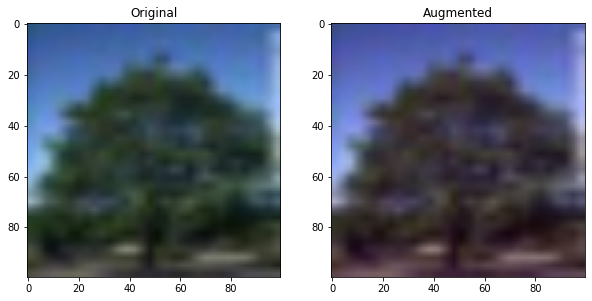

In [2]:
import json 
import cv2 as cv
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt

json_path = '/content/cifar50/cifar50_train.json'
with open(json_path) as f:
  data = json.load(f)

def get_image(index):
  img_path = data['annotations'][index]['fpath']
  pillow_image = Image.open(img_path)
  img = np.array(pillow_image)
  return img

transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5)
    ]
)

original_image = get_image(12)
augmented_image = transform(image=original_image)['image']

original_resized = cv.resize(original_image, (100, 100))
augmented_resized = cv.resize(augmented_image, (100, 100))

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].set_title("Original")
ax[0].imshow(original_resized)
ax[1].set_title("Augmented")
_ = ax[1].imshow(augmented_resized)

### --- Define Dataset ---

In [7]:
from torch.utils.data import Dataset  
import albumentations as A 

class BaseDataset(Dataset):
  def __init__(self, input, da=False):
    if isinstance(input, str):
      with open(input) as f:
        json_data = json.load(f)
        self.data = json_data['annotations']
    elif isinstance(input, list):
      self.data = input

    self.da = da
    self.transform = A.Compose(
      [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5)
      ]
    )
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    # --------- Inner functions ------------
    def get_image(index):
      img_path = self.data[index]['fpath']
      pillow_image = Image.open(img_path)
      img = np.array(pillow_image)
      return img

    def get_category_id(index):
      id = self.data[index]['category_id']
      # DIVIDE BY 2
      return id // 2
    
    def toTensor(img):
      ToTensor = ToTensorV2()
      return ToTensor.apply(img)
    # --------------------------------------

    image = get_image(idx)
    category_id = get_category_id(idx)
    if self.da is True:
      img_tensor = toTensor(self.transform(image=image)['image'])
      sample = (img_tensor, category_id)
    else:
      img_tensor = toTensor(image)
      sample = (img_tensor, category_id)
    return sample

### --- Define DataLoader ---

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Prep Json files
train_json = '/content/cifar50/cifar50_train.json'
test_json = '/content/cifar50/cifar50_test.json'

def get_dataloaders(batch_size=16, num_workers=2, da=False):
  # Create Base Dataset
  dataset = BaseDataset(train_json, da)

  # Calculate Split
  val_split = 0.2   # Hardcoded 20%
  dataset_size = len(dataset)
  indices = list(range(dataset_size))
  split = int(np.floor(val_split * dataset_size)) 

  # Shuffle Data
  np.random.seed(42)
  np.random.shuffle(indices)

  # Split Base Dataset into Training and Validation Datasets
  train_indices, val_indices = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)

  # Create Test Dataset
  testset = BaseDataset(test_json)

  # Dataloaders
  train_dataloader = DataLoader(dataset, batch_size, num_workers=num_workers, sampler=train_sampler)
  val_dataloader = DataLoader(dataset, batch_size, num_workers=num_workers, sampler=val_sampler)
  test_dataloader = DataLoader(testset, batch_size, num_workers=num_workers)

  return train_dataloader, val_dataloader, test_dataloader

### --- Test Dataloader Data Augmentation ---

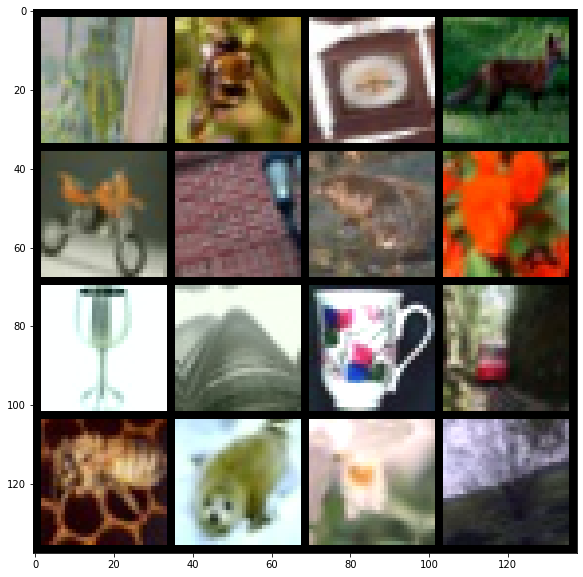

In [5]:
import torchvision

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(da=True)

images, labels = next(iter(train_dataloader))
single_batch_grid = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize = (10,10))
_ = plt.imshow(single_batch_grid.permute(1, 2, 0))

## --------- Data Balancing Strategies ---------


### Approach #1 Artifical Balancing

Upsample (data augmentation) on minority classes and downsample majority classes to satisfy a desired sample threshold.

#### I. Artifical Balancing Algorithm 
```python
# imbalanced_json : json file path
# balanced_dirname : string
def generate_dataset(imbalanced_json, balanced_dirname, target=400)
```

In [18]:
import math
import json
from pathlib import Path
import random
import shutil
from PIL import Image

In [13]:
# Utils 
from collections import Counter

def process_json(json_path):
  with open(json_path) as f:
    data = json.load(f)  
  return data['annotations']

def get_histogram(input): # list of json data
  if isinstance(input, str):
    json_data = process_json(input)
    category_ids = [entry['category_id'] // 2 for entry in json_data]
    hist = Counter(category_ids)
  else:
    json_data = input
    category_ids = [entry['category_id'] // 2 for entry in json_data]
    hist = Counter(category_ids)
  return hist

def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

def get_sample_rates(hist, target):
    rates = {id: truncate(target / count, 3) if count < target   # Oversampling Rate
             else truncate(target/count, 3)   # Subsampling Rate
             for id, count in hist.items()}
    return rates 

def target_sampling(json_data, target):
  hist = get_histogram(json_data)
  rates = get_sample_rates(hist, target)
  return rates

In [14]:
def augment_image(fpath):
  pillow_image = Image.open(fpath)
  img = np.array(pillow_image)
  transform = A.Compose(
      [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5)
      ]
  )
  augmented = transform(image=img)['image']
  return augmented

In [19]:
# Datset object
class OutputDataset:
  def __init__(self, dirname):
    self.dirname = dirname
    self.train_json = {}
    self.train_json['annotations'] = []
    self.train_json['num_classes'] = 50
    self.image_id = 0

    # Create File Directory
    base_dir = Path.cwd() / dirname
    base_dir.mkdir(parents=True, exist_ok =True)

    classes = [x for x in Path('./cifar50/images').iterdir() if x.is_dir()]
    for cl in classes: 
      sub_dir = Path(base_dir) / 'images' / cl.stem
      sub_dir.mkdir(parents=True, exist_ok =True)
    
  def add_image(self, obj, augmented_image=None):  # augmented_image will be of numpy array type
    fpath = f"./{self.dirname}/images/{obj['category']}/train_{self.image_id}.jpg"

    # Add Json Entry
    entry = {
      'category': obj['category'],
      'category_id': obj['category_id'],
      'fpath': fpath,
      'image_id': self.image_id
    }
    self.train_json['annotations'].append(entry)

    # Either Copy Existing or Write Image
    if augmented_image is None:
      src = obj['fpath']
      dest = fpath
      shutil.copy(src, dest)
    else:
      im = Image.fromarray(augmented_image)
      im.save(fpath)
     
    # Terminal Feedback 
    if self.image_id % 1000 == 0:
      print(f"Current Image Id: {self.image_id} / {self.max_image_cnt}")
    self.image_id += 1

  def publish_json(self):
    # Publish Train Json
    with open(f'/content/{self.dirname}/{self.dirname}_train.json', 'w') as outfile:
      json.dump(self.train_json, outfile)

    # Transfer/Rename Test Json
    src = '/content/cifar50/cifar50_test.json'
    dest = f'/content/{self.dirname}/{self.dirname}_test.json'
    shutil.copy(src, dest)   # Note, does not fix the test fpaths, whoops :P
  
  def setTarget(self, target):
    self.max_image_cnt = target * 50

In [22]:
# Target Sample Algorithm 
def generate_dataset(imbalanced_json, balanced_dirname, target=400):
  # 1) Get sampling rates
  rates = target_sampling(imbalanced_json, target)

  # 2) Prepare output directory
  dataset = OutputDataset(balanced_dirname)
  dataset.setTarget(target)
  print(f"---- Balancing {Path(imbalanced_json).stem} ----")

  # 3) Write images to directory
  with open(imbalanced_json) as f:
    json_data = json.load(f) 
  for obj in json_data['annotations']:
    rate = rates[obj['category_id'] // 2]
    random_num = random.uniform(0, 1)
    # Downsample
    if rate < 1: 
      if random_num < rate:   # Otherwise, discard the image!
        dataset.add_image(obj)  
    # Upsample
    else:  
      # Transfer base
      dataset.add_image(obj) 
      
      # Augment remaining
      num_augments = int(rate - 1)
      for _ in range(num_augments):
        dataset.add_image(obj, augmented_image=augment_image(obj['fpath']))

      probability = truncate(rate - int(rate), 3) 
      if random_num < probability:
        dataset.add_image(obj, augmented_image=augment_image(obj['fpath']))

  # 4) Write Json's to directory 
  dataset.publish_json()

#### II. Create Datasets

In [ ]:
# Reset All Datasets
!rm -rf cifar50_balanced_0.1
!rm -rf cifar50_balanced_0.02
!rm -rf cifar50_balanced_0.005

In [23]:
imbalanced_jsons = ['/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_train.json',
                    '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json',
                    '/content/cifar50_imbalance_0.005/cifar50_imbalance_0.005_train.json']

balanced_dirs = ["cifar50_balanced_0.1",
                  "cifar50_balanced_0.02",
                  "cifar50_balanced_0.005"]

target = 300
for imbalanced_json, balanced_dir in list(zip(imbalanced_jsons, balanced_dirs)):
  generate_dataset(imbalanced_json, balanced_dir, target)

---- Balancing cifar50_imbalance_0.1_train ----
Current Image Id: 0 / 15000
Current Image Id: 1000 / 15000
Current Image Id: 2000 / 15000
Current Image Id: 3000 / 15000
Current Image Id: 4000 / 15000
Current Image Id: 5000 / 15000
Current Image Id: 6000 / 15000
Current Image Id: 7000 / 15000
Current Image Id: 8000 / 15000
Current Image Id: 9000 / 15000
Current Image Id: 10000 / 15000
Current Image Id: 11000 / 15000
Current Image Id: 12000 / 15000
Current Image Id: 13000 / 15000
Current Image Id: 14000 / 15000
---- Balancing cifar50_imbalance_0.02_train ----
Current Image Id: 0 / 15000
Current Image Id: 1000 / 15000
Current Image Id: 2000 / 15000
Current Image Id: 3000 / 15000
Current Image Id: 4000 / 15000
Current Image Id: 5000 / 15000
Current Image Id: 6000 / 15000
Current Image Id: 7000 / 15000
Current Image Id: 8000 / 15000
Current Image Id: 9000 / 15000
Current Image Id: 10000 / 15000
Current Image Id: 11000 / 15000
Current Image Id: 12000 / 15000
Current Image Id: 13000 / 15000
C

In [ ]:
# Download Datasets to Local Machine
from google.colab import files

!zip -r /content/file1.zip /content/cifar50_balanced_0.005
files.download("/content/file1.zip")
!zip -r /content/file2.zip /content/cifar50_balanced_0.02
files.download("/content/file2.zip")
!zip -r /content/file3.zip /content/cifar50_balanced_0.1
files.download("/content/file3.zip")

#### III. Verify Output

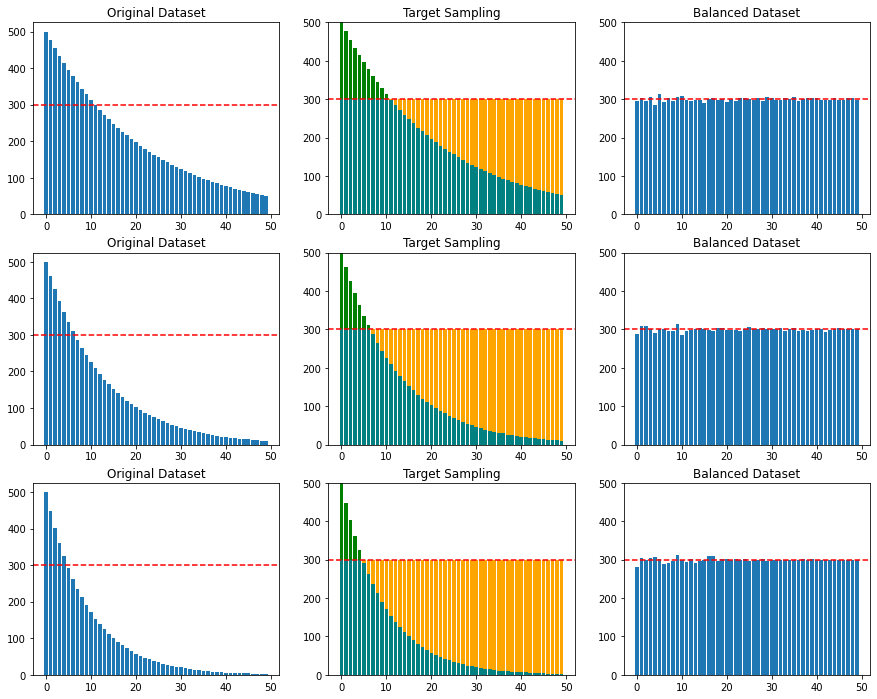

In [24]:
imbalanced_hists = [get_histogram(imbalanced_json) for imbalanced_json in imbalanced_jsons]

def balanced_json_path(name):
  return f'/content/{name}/{name}_train.json'
balanced_hists = [get_histogram(balanced_json_path(name)) for name in balanced_dirs]

fig, ax = plt.subplots(3, 3, figsize=(15, 12))
for row, (imbalanced_hist, balanced_hist) in enumerate(zip(imbalanced_hists, balanced_hists)):
  # Visual Components
  downsampled = {cl: cnt if cnt > target else 0
                for cl, cnt in imbalanced_hist.items()}
  original = {cl: target if cnt > target else cnt
                for cl, cnt in imbalanced_hist.items()}
  upsampled = {cl: target if cnt < target else 0
                for cl, cnt in imbalanced_hist.items()}

  # Plot 
  ax[row][0].set_title("Original Dataset")
  ax[row][0].bar(imbalanced_hist.keys(), imbalanced_hist.values())
  ax[row][0].axhline(y=target, color='r', linestyle='--')

  ax[row][1].set_title("Target Sampling")
  ax[row][1].bar(downsampled.keys(), downsampled.values(), color='green')
  ax[row][1].bar(upsampled.keys(), upsampled.values(), color='orange')
  ax[row][1].bar(original.keys(), original.values(), color='teal') 
  ax[row][1].axhline(y=target, color='r', linestyle='--')
  ax[row][1].set_ylim([0, 500])

  ax[row][2].set_title("Balanced Dataset")
  ax[row][2].bar(balanced_hist.keys(), balanced_hist.values())
  ax[row][2].axhline(y=target, color='r', linestyle='--')
  _ = ax[row][2].set_ylim([0, 500])

#### IV. Hyperparameter Tuning: Target Value
What is the ideal level of downsampling / upsampling for each imbalanced dataset? <br>

In [25]:
# ---- Create Datasets ----
# Adjusting target hyperparameter on medium-unbalanced dataset
imbalanced_json = '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json'

balanced_dirs = ["cifar50_balanced_0.02_L",
                 "cifar50_balanced_0.02_H"]

targets = [200, 400]
for balanced_dir, target in list(zip(balanced_dirs, targets)):
  generate_dataset(imbalanced_json, balanced_dir, target)

---- Balancing cifar50_imbalance_0.02_train ----
Current Image Id: 0 / 10000
Current Image Id: 1000 / 10000
Current Image Id: 2000 / 10000
Current Image Id: 3000 / 10000
Current Image Id: 4000 / 10000
Current Image Id: 5000 / 10000
Current Image Id: 6000 / 10000
Current Image Id: 7000 / 10000
Current Image Id: 8000 / 10000
Current Image Id: 9000 / 10000
---- Balancing cifar50_imbalance_0.02_train ----
Current Image Id: 0 / 20000
Current Image Id: 1000 / 20000
Current Image Id: 2000 / 20000
Current Image Id: 3000 / 20000
Current Image Id: 4000 / 20000
Current Image Id: 5000 / 20000
Current Image Id: 6000 / 20000
Current Image Id: 7000 / 20000
Current Image Id: 8000 / 20000
Current Image Id: 9000 / 20000
Current Image Id: 10000 / 20000
Current Image Id: 11000 / 20000
Current Image Id: 12000 / 20000
Current Image Id: 13000 / 20000
Current Image Id: 14000 / 20000
Current Image Id: 15000 / 20000
Current Image Id: 16000 / 20000
Current Image Id: 17000 / 20000
Current Image Id: 18000 / 20000


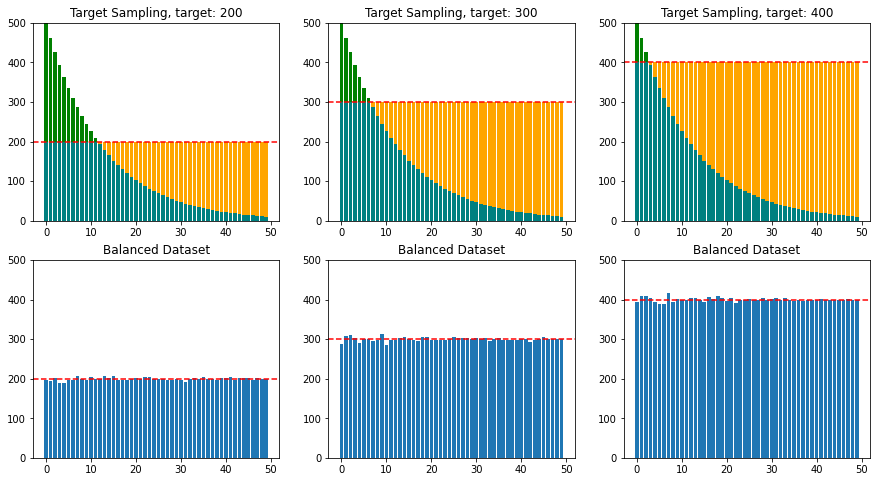

In [26]:
# ---- Verify Output ----
def balanced_json_path(name):
  return f'/content/{name}/{name}_train.json'

imbalanced_hist = get_histogram(imbalanced_json)
balanced_L = get_histogram(balanced_json_path("cifar50_balanced_0.02_L"))
balanced_M = get_histogram('/content/cifar50_balanced_0.02/cifar50_balanced_0.02_train.json')
balanced_H = get_histogram(balanced_json_path("cifar50_balanced_0.02_H"))
balanced_hists = [balanced_L] + [balanced_M] + [balanced_H]
targets = [200, 300, 400]

fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for col, target in enumerate(targets):
  # Visual Components
  downsampled = {cl: cnt if cnt > target else 0
                for cl, cnt in imbalanced_hist.items()}
  original = {cl: target if cnt > target else cnt
                for cl, cnt in imbalanced_hist.items()}
  upsampled = {cl: target if cnt < target else 0
                for cl, cnt in imbalanced_hist.items()}

  ax[0][col].set_title(f"Target Sampling, target: {target}")
  ax[0][col].bar(downsampled.keys(), downsampled.values(), color='green')
  ax[0][col].bar(upsampled.keys(), upsampled.values(), color='orange')
  ax[0][col].bar(original.keys(), original.values(), color='teal') 
  ax[0][col].axhline(y=target, color='r', linestyle='--')
  ax[0][col].set_ylim([0, 500])

for col, (balanced_hist, target) in enumerate(zip(balanced_hists, targets)):
  # Balanced Plots 
  ax[1][col].set_title("Balanced Dataset")
  ax[1][col].bar(balanced_hist.keys(), balanced_hist.values())
  ax[1][col].axhline(y=target, color='r', linestyle='--')
  _ = ax[1][col].set_ylim([0, 500])

In [ ]:
# Download Datasets to Local Machine
from google.colab import files

!zip -r /content/file4.zip /content/cifar50_balanced_0.02_L
files.download("/content/file4.zip")
!zip -r /content/file5.zip /content/cifar50_balanced_0.02_H
files.download("/content/file5.zip")

### Approach #2: Smart-Bagging

#### I. Smart Bagging Algorithm 
Create N balanced datasets from an imbalanced dataset by duplicating the minority classes and evenly distributing the majority classes. Each balanced dataset is used to train an ensemble model. Boundary between majority and minority classes is controlled by input hyperparameter sampling threshold.


In [4]:
# Utils
from collections import Counter

def process_json(json_path):
  with open(json_path) as f:
    data = json.load(f)  
  return data['annotations']

def get_histogram(input): # list of json data
  if isinstance(input, str):
    json_data = process_json(input)
    category_ids = [entry['category_id'] // 2 for entry in json_data]
    hist = Counter(category_ids)
  else:
    json_data = input
    category_ids = [entry['category_id'] // 2 for entry in json_data]
    hist = Counter(category_ids)
  return hist

def split_histogram(hist, data, threshold):
  # Find class corresponding to threshold
  bimap = dict(reversed(item) for item in hist.items())
  nearest_cnt = min(hist.values(), key=lambda x:abs(x-threshold))
  cl = bimap[nearest_cnt]

  # Divide distribution
  sorted_data = sorted(data, key=lambda x: hist[x['category_id']], reverse=True)  # sort classes by frequency  
  category_ids = [entry['category_id'] for entry in sorted_data]
  split = category_ids.index(cl) # Find first instance of cl
  majority = sorted_data[:split]
  minority = sorted_data[split:]
  return majority, minority

In [5]:
import random 

def create_bags(imbalanced_json, threshold=200):
  # 1) Load Data
  entries = process_json(imbalanced_json)

  # 2) Calculate Number of Learners
  hist = get_histogram(entries)
  num_bags = max(hist.values()) // threshold

  # 3) Create Datasets
  majority, minority = split_histogram(hist, entries, threshold)
  random.shuffle(majority)
  bags = []
  for start in range(num_bags):
    current_bag = majority[start::num_bags] + minority  # we toss out some samples and thats okay
    bags.append(BaseDataset(current_bag)) 

  return bags

#### II. Create Datasets

In [9]:
from pathlib import Path
import json

imbalanced_jsons = ['/content/cifar50_imbalance_0.1/cifar50_imbalance_0.1_train.json',
                    '/content/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json',
                    '/content/cifar50_imbalance_0.005/cifar50_imbalance_0.005_train.json']

thresholds = [150, 120, 75]

datasets = []
for imbalanced_json, threshold in zip(imbalanced_jsons, thresholds):
  bags = create_bags(imbalanced_json, threshold)
  quantity = len(bags)
  print(f'{Path(imbalanced_json).stem}, Num Learners: {quantity}')
  datasets.append({'bags': bags, "threshold": threshold, "quantity": quantity})

cifar50_imbalance_0.1_train, Num Learners: 3
cifar50_imbalance_0.02_train, Num Learners: 4
cifar50_imbalance_0.005_train, Num Learners: 6


#### III. Verify Output

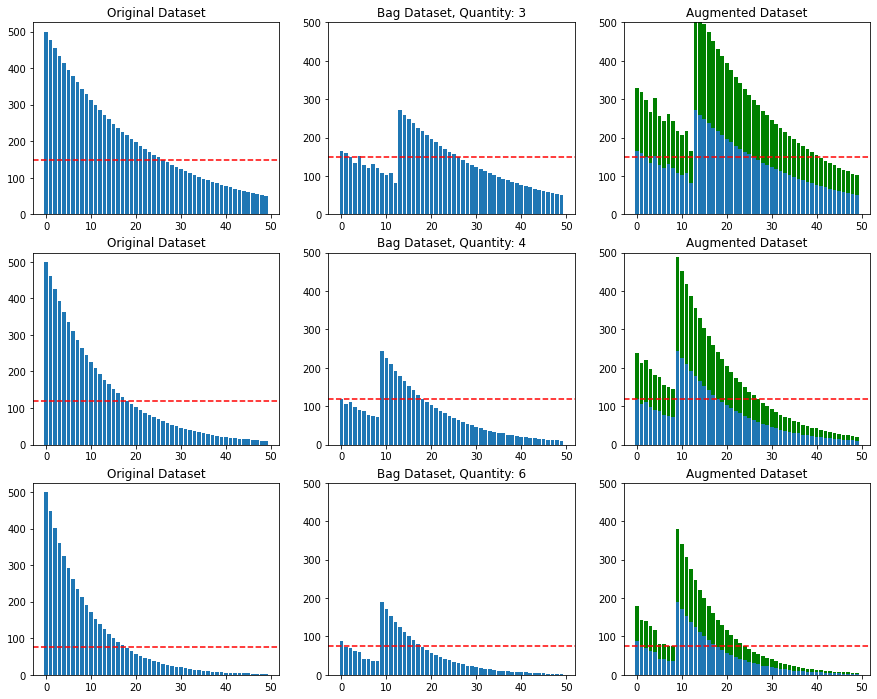

In [10]:
import matplotlib.pyplot as plt

imbalanced_hists = [get_histogram(imbalanced_json) for imbalanced_json in imbalanced_jsons]

fig, ax = plt.subplots(3, 3, figsize=(15, 12))
for row, (imbalanced_hist, dataset) in enumerate(zip(imbalanced_hists, datasets)):
  # Dataset Specific
  bag_hist = get_histogram(dataset['bags'][0].data)
  augmented_hist = {cl: cnt * 2 for cl, cnt in bag_hist.items()}

  # Plot 
  ax[row][0].set_title("Original Dataset")
  ax[row][0].bar(imbalanced_hist.keys(), imbalanced_hist.values())
  ax[row][0].axhline(y=dataset['threshold'], color='r', linestyle='--')

  ax[row][1].set_title(f"Bag Dataset, Quantity: {dataset['quantity']}")
  ax[row][1].bar(bag_hist.keys(), bag_hist.values())
  ax[row][1].axhline(y=dataset['threshold'], color='r', linestyle='--')
  ax[row][1].set_ylim([0, 500])

  ax[row][2].set_title("Augmented Dataset")
  ax[row][2].bar(augmented_hist.keys(), augmented_hist.values(), color='green')
  ax[row][2].bar(bag_hist.keys(), bag_hist.values())
  ax[row][2].axhline(y=dataset['threshold'], color='r', linestyle='--')
  _ = ax[row][2].set_ylim([0, 500])

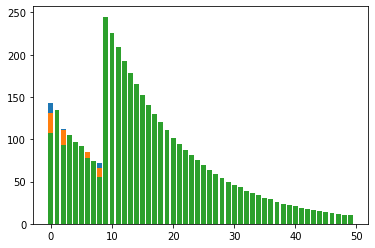

In [17]:
import matplotlib.pyplot as plt
# Individual Bag Distributions:
bag_hist = get_histogram(datasets[1]['bags'][1].data)
bag_hist1 = get_histogram(datasets[1]['bags'][2].data)
bag_hist2 = get_histogram(datasets[1]['bags'][3].data)

plt.bar(bag_hist.keys(), bag_hist.values())
plt.bar(bag_hist1.keys(), bag_hist1.values())
_ = plt.bar(bag_hist2.keys(), bag_hist2.values())

Due to fewer data samples, meta-learner may be a viable architecture for the ensamble learners (if a set of pretrained weights can be found). Data augmentation appears to exacerbate class imbalance so we will avoid it. If pre-trained meta learner architecture cannot be found, we will rely on a powerful feature extractor.  

## This concludes prototyping of data balancing strategies! Full training scripts may be found in project directory.